In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
tf.config.list_physical_devices('GPU')

2024-05-21 12:52:57.757403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 12:52:57.757475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 12:52:57.789971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 12:52:57.866353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 12:52:58.976273: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_dir = '../../Dataset_Scripts/Datasets/Dataset_R2_Uniform/train/circles/'
test_dir = '../../Dataset_Scripts/Datasets/Dataset_R2_Uniform/test/circles/'

In [3]:
IMG_SIZE = 250
BATCH_SIZE = 32

In [4]:
import pandas as pd
data_df = pd.read_csv('../../Dataset_Scripts/Datasets/Dataset_R2_Uniform/data/circles_big.csv')
train_df = data_df[data_df['Variant'] == 'Train']
test_df = data_df[data_df['Variant'] == 'Test']

In [5]:
# Remove other columns and keep only the 'Proportion' and Filename columns
train_df = train_df[['Proportion', 'Filename']]
test_df = test_df[['Proportion', 'Filename']]

In [6]:
print(train_df.head())

   Proportion       Filename
0       8.693  circles_1.png
1      35.408  circles_2.png
2      13.812  circles_3.png
3      23.134  circles_4.png
4      20.995  circles_5.png


In [7]:
gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = gen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='Filename',
    y_col='Proportion',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_generator = gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='Filename',
    y_col='Proportion',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 10996 validated image filenames.
Found 5000 validated image filenames.


In [8]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(1)(x) 
model = keras.Model(inputs=inputs, outputs=outputs)

2024-05-21 12:55:21.337284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 12:55:21.337758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 12:55:21.338081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
model.summary()

In [9]:
model.compile(loss="mse", optimizer="adam" , metrics=["mae"])

In [11]:
checkpoint_filepath = 'models/R2_Uniform/ch-{epoch:03d}.ckpt'
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

callbacks = [model_checkpoint, early_stop]


In [12]:
history = model.fit(train_generator, epochs=100, batch_size=32, verbose=1, validation_data=test_generator, callbacks=[callbacks])

Epoch 1/100


2024-05-21 12:57:05.024472: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-21 12:57:05.284764: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 12:57:07.743235: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-21 12:57:08.332224: I external/local_xla/xla/service/service.cc:168] XLA service 0x93c5cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 12:57:08.332254: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2024-05-21 12:57:08.361873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716292628.531335   10205 dev

344/344 [==============================] - ETA: 0s - loss: 223.5156 - mae: 12.7760
Epoch 1: val_loss improved from inf to 217.22690, saving model to models/R2_Uniform/ch-001.ckpt
INFO:tensorflow:Assets written to: models/R2_Uniform/ch-001.ckpt/assets


INFO:tensorflow:Assets written to: models/R2_Uniform/ch-001.ckpt/assets


344/344 [==============================] - 88s 231ms/step - loss: 223.5156 - mae: 12.7760 - val_loss: 217.2269 - val_mae: 12.6445
Epoch 2/100
344/344 [==============================] - ETA: 0s - loss: 204.4415 - mae: 12.3848
Epoch 2: val_loss improved from 217.22690 to 211.65816, saving model to models/R2_Uniform/ch-002.ckpt
INFO:tensorflow:Assets written to: models/R2_Uniform/ch-002.ckpt/assets


INFO:tensorflow:Assets written to: models/R2_Uniform/ch-002.ckpt/assets


344/344 [==============================] - 69s 199ms/step - loss: 204.4415 - mae: 12.3848 - val_loss: 211.6582 - val_mae: 12.5367
Epoch 3/100
344/344 [==============================] - ETA: 0s - loss: 203.3312 - mae: 12.3533
Epoch 3: val_loss did not improve from 211.65816
344/344 [==============================] - 66s 191ms/step - loss: 203.3312 - mae: 12.3533 - val_loss: 214.2182 - val_mae: 12.5987
Epoch 4/100
344/344 [==============================] - ETA: 0s - loss: 203.1462 - mae: 12.3489
Epoch 4: val_loss improved from 211.65816 to 203.91405, saving model to models/R2_Uniform/ch-004.ckpt
INFO:tensorflow:Assets written to: models/R2_Uniform/ch-004.ckpt/assets


INFO:tensorflow:Assets written to: models/R2_Uniform/ch-004.ckpt/assets


344/344 [==============================] - 69s 201ms/step - loss: 203.1462 - mae: 12.3489 - val_loss: 203.9140 - val_mae: 12.3849
Epoch 5/100
344/344 [==============================] - ETA: 0s - loss: 202.4942 - mae: 12.3294
Epoch 5: val_loss improved from 203.91405 to 203.20869, saving model to models/R2_Uniform/ch-005.ckpt
INFO:tensorflow:Assets written to: models/R2_Uniform/ch-005.ckpt/assets


INFO:tensorflow:Assets written to: models/R2_Uniform/ch-005.ckpt/assets


344/344 [==============================] - 91s 263ms/step - loss: 202.4942 - mae: 12.3294 - val_loss: 203.2087 - val_mae: 12.3711
Epoch 6/100
344/344 [==============================] - ETA: 0s - loss: 202.3127 - mae: 12.3344
Epoch 6: val_loss did not improve from 203.20869
344/344 [==============================] - 72s 208ms/step - loss: 202.3127 - mae: 12.3344 - val_loss: 203.8219 - val_mae: 12.3830
Epoch 7/100
344/344 [==============================] - ETA: 0s - loss: 202.1567 - mae: 12.3406
Epoch 7: val_loss did not improve from 203.20869
344/344 [==============================] - 73s 212ms/step - loss: 202.1567 - mae: 12.3406 - val_loss: 207.2399 - val_mae: 12.4568
Epoch 8/100
344/344 [==============================] - ETA: 0s - loss: 203.6174 - mae: 12.3596
Epoch 8: val_loss did not improve from 203.20869
344/344 [==============================] - 76s 219ms/step - loss: 203.6174 - mae: 12.3596 - val_loss: 203.3617 - val_mae: 12.3754
Epoch 9/100
344/344 [===========================

In [13]:
# save history to file
import pickle
with open('models/R2_Uniform/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


FileNotFoundError: [Errno 2] No such file or directory: 'models/8/history1.pkl'

In [14]:
# save model
model.save('models/R2_Uniform/model.keras')

In [ ]:
loss = model.evaluate(test_generator)

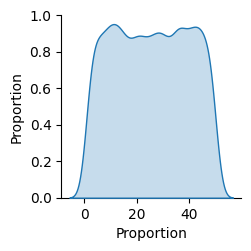

In [15]:
import seaborn as sns
sns.pairplot(train_df, diag_kind='kde')

In [16]:
new_genetator = gen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='Filename',
    y_col='Proportion',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='raw',
    batch_size=1,
)

Found 5000 validated image filenames.


In [17]:
# run thorugh all batches in the test generator and save predictions and true values into a csv
predictions = []
true_values = []

for i in range(len(new_genetator)):
    x, y = test_generator[i]
    predictions += list(model.predict(x).flatten())
    true_values += list(y)

1/1 [==============================] - 0s 82ms/step


ValueError: Asked to retrieve element 157, but the Sequence has length 157

In [18]:
df = pd.DataFrame({'True Area': true_values, 'Predicted Area': predictions, 'Difference': np.abs(np.array(true_values) - np.array(predictions))}, index=new_genetator.filenames)
df.to_csv('predictions.csv')

In [ ]:
# get a batch of test data

# get the predictions for the test batch
predictions = []
for test_data in next(test_generator):
    predictions = predictions.append(model.predict(test_data[i]))
    # get the target values for the test batch
    true_value = test_data
    for i in range(len(predictions)):
        print(f"Predicted: {predictions[i][0]:}, True Value: {true_value[i]:}")

In [19]:
len(predictions)

5000

In [ ]:
# make csv with predictions and true values
df = pd.DataFrame(data={'Predicted': predictions.flatten(), 'True Value': true_value})
df.to_csv('predictions.csv', index=False)

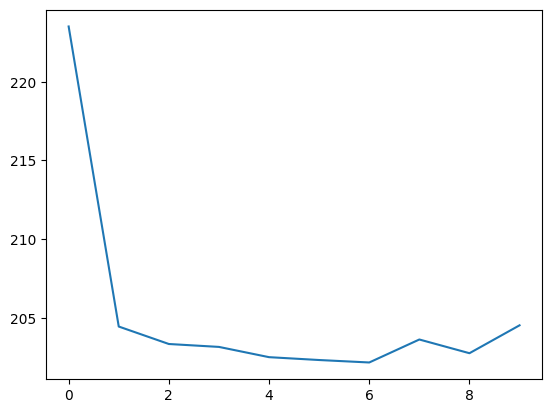

In [20]:
# plot of loss
plt.plot(history.history['loss'])
#plt.savefig('graphs/loss.png')

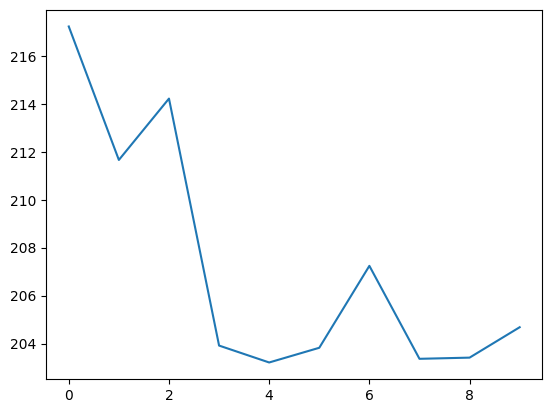

In [22]:
plt.plot(history.history['val_loss'])

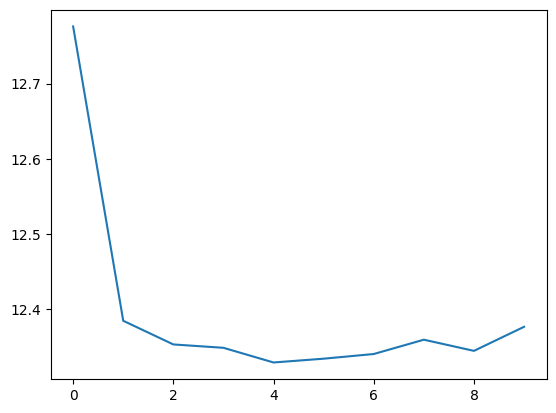

In [21]:
# plot of mean absolute error
plt.plot(history.history['mae'])
plt.savefig('graphs/mae.png')

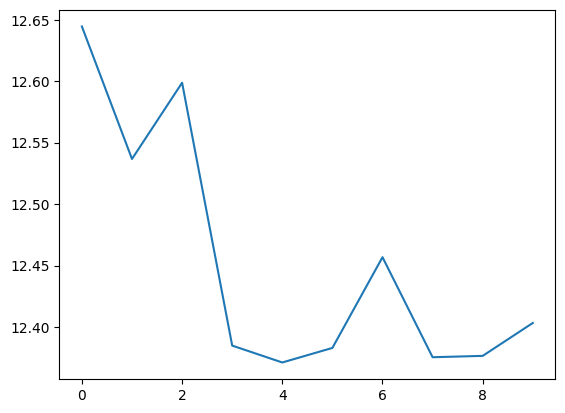

In [23]:
plt.plot(history.history['val_mae'])

In [ ]:
ypred = model.predict(test_generator)

In [ ]:
# Show predictions
images, true_values = next(test_generator)
predictions = model.predict(images)

In [ ]:
print("Predictions:", predictions)

In [ ]:
# Show 6 samples
for i in range(6):
    print("True value:", true_values[i])
    print("Predicted value:", predictions[i])
    # Display the image
    plt.imshow(images[i])
    plt.show()

In [ ]:
print(ypred)

In [ ]:
for i in range(10):
    print(ypred[i], test_generator[i][1][i])

In [ ]:
batch = 0
for image, label in test_generator.take(1):
    for i in range(len(image)):
        plt.imshow(image[i])
        plt.show()
        prediction = model.predict(image[i].numpy().reshape(1, 250, 250, 3))
        print(prediction)
        print(label[i])
        break
    break

In [ ]:
# Predict gives always the same value
batch = 1
index = 1
plt.imshow(test_data_generator[batch][0][index])
plt.show()
print('True Proportion:', test_data_generator[batch][1][index])
print('Predicted Proportion:', model.predict(test_data_generator[batch][0][index].reshape(1, 250, 250, 3)))


In [ ]:
batch = 1
index = 2
plt.imshow(test_data_generator[batch][0][index])
plt.show()
print('True Proportion:', test_data_generator[batch][1][index])
print('Predicted Proportion:', model.predict(test_data_generator[batch][0][index].reshape(1, 250, 250, 3)))